We test the SVM class we implemented.

In [11]:
import matplotlib.pyplot as plt
%pylab inline

from sklearn.model_selection import train_test_split

import numpy as np

from SVM import SVM

Populating the interactive namespace from numpy and matplotlib


Text(0.5,1,'2 Gaussian blobs')

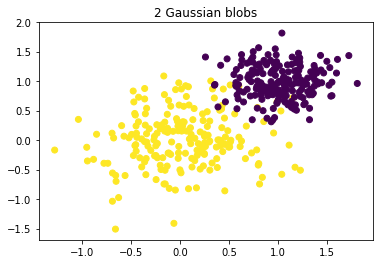

In [12]:
# Data generation
n_samples = 200

blob1 = np.random.multivariate_normal([0,0], 0.2*np.eye(2), n_samples)
blob2 = np.random.multivariate_normal([1,1], 0.07*np.eye(2), n_samples)

X = np.concatenate((blob1, blob2))
X = np.concatenate((X, np.ones((n_samples*2,1))), axis=1) # to account for offset
y = np.concatenate((np.ones(n_samples), -np.ones(n_samples)))

plt.scatter(X[:,0], X[:,1], c=y)
plt.title("2 Gaussian blobs")

In [6]:
# Train/test split, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42)

In [7]:
classif = SVM(tau=0.01)

In [8]:
classif.fit(X_train, y_train)

In [9]:
w_opt = classif.get_weights()

Text(0.5,1,'SVM hyperplan vizualization')

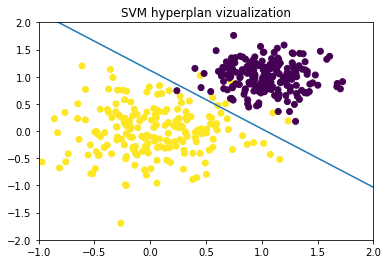

In [10]:
plt.scatter(X[:,0], X[:,1], c=y)

plt.plot(np.linspace(-5,5, 10), [-(w_opt[0]*x + w_opt[2])/w_opt[1] 
                                 for x in np.linspace(-5,5,10)])
plt.xlim(-1 ,2)
plt.ylim(-2, 2)
plt.title('SVM hyperplan vizualization')

In [13]:
X.shape

(400, 3)